<a href="https://colab.research.google.com/github/nutyfreshz/MADT8101_Customer_Analytics/blob/main/EP_5_CLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLV formula**

**Customer lifetime value (CLV)** is a metric that represents the monetary worth of a customer over the entire duration of their relationship with a business. It is calculated based on the present value of the projected future cash flows expected to be generated from the customer. There are two main types of CLV:

* Historic CLV: This is determined by calculating the total revenue generated from all orders placed by the customer up to the present date.

* Predicted CLV: This estimate considers the total amount of money the customer is expected to spend in the future, typically within the next year or a specific timeframe

## Method 1: APRU (Simplest: Rule of Three)

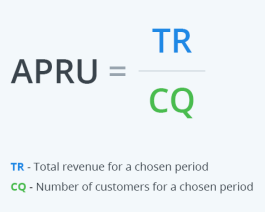

Let’s suppose 20 customers brought $1,240 in profit over a three-month period.

ARPU (3 months) = $1240 / 20 = $62

Let’s see what these customers will bring us in one year.

ARPU (12 months) = ARPU (3 months) × 4 = $62 × 4 = $248 per year per customer

## **Method 2: CLV Equation**

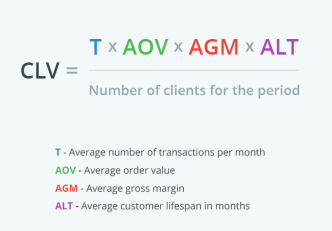

1. Calculate the average number of transactions (T):

Period: 6 months
Total transactions: 120
T = 120 / 6 = 20

2. AOV is the average value of an order, or the average revenue from each order.
  * Total revenue: 12,000 USD
  * Number of orders: 20
  * AOV = 12,000 USD / 20 = 600 USD



3. AGM is the average gross margin by month.

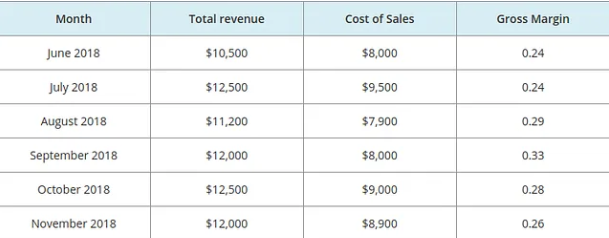

4. Churn rate (%) = (200–150) / 200 = 50 / 200 = 0.25, or 25%

  * ALT = 1 / 25% = 1 / 0.25 = 4 months

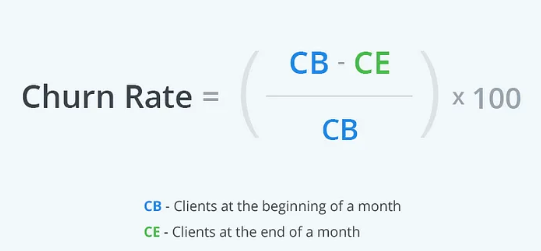


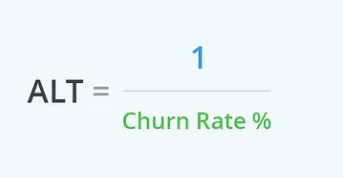

## **Method 3: Standard CLV Formula**

CLV = (Contribution Margin * (1 - Discount Rate)) / (1 - Retention Rate)

* Contribution Margin = Revenue earned from serving a customer - VC (Variable Cost) spent in serving the
customer = ARPU (Average Revenue Per User) - VC
* Discount Rate = 100 USD in 2050 is less valuable than 100 USD today, so, we will discount the profit earned to get the
present value of the money.
* Churn Rate= Percentage of customers that leave the platform.
* Retention Rate = 1 - The churn rate = Percentage of customers who stay on the platform. It can also be
calculated as, ((Ce-Cn)/Cs))x100.

where:
  * Ce = Number of customers at the end of a given period,
  * Cn = Number of new customers acquired during a given period,
  * Cs = Number of customers at the beginning of a given period.

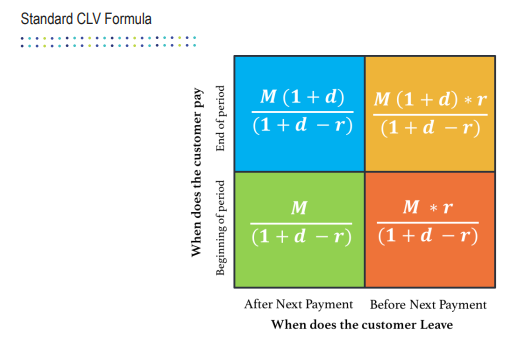

##**Method 4: “Buy ‘Til You Die” probabilistic models in Python**

* “Buy ‘Til You Die” probabilistic models help us in quantifying the lifetime value of a customer by assessing the
expected number of his future transactions and his probability of being “alive”.

### **How to calculate "Buy Till You Die Model"**

* lifetimes package is our main library

In [ ]:
!pip install lifetimes

import lifetimes
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter # BG/NBD
from lifetimes import GammaGammaFitter # Gamma-Gamma Model
from lifetimes.plotting import plot_frequency_recency_matrix
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Before we calculate CLV please be aware of outlier.

In [ ]:
def find_boundaries (df, variable, q1 = 0.05, q2 = 0.95):
  # The boundaries are the quantiles
  lower_boundary = df[variable].quantile(q1)
  upper_boundary = df[variable].quantile(q2)

  return upper_boundary, lower_boundary

def capping_outliers (df, variable):
  upper_boundary, lower_boundary = find_boundaries(df, variable)
  df[variable] = np.where(df[variable] > upper_boundary,upper_boundary,
                          np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [ ]:
clv = lifetimes.utils.summary_data_from_transaction_data(df,
                                                         'CustomerID',
                                                         'InvoiceDate',
                                                         'TotalPrice',
                                                         observation_period_end = enddate)

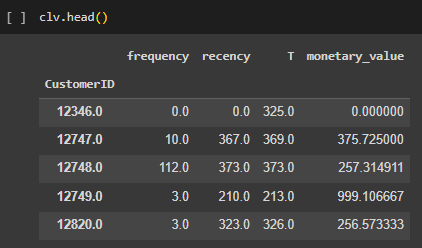

* Frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

* Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

* T represents the age of the customer at whatever time units are chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

* Monetary Value represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

### **BG/NBD model**

In [ ]:
bgf = BetaGeoFitter(penalizer_coef = 0.001)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])

t = 180 # 30 day period
clv['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                        clv['frequency'],
                                                                                        clv['recency'],
                                                                                        clv['T'])

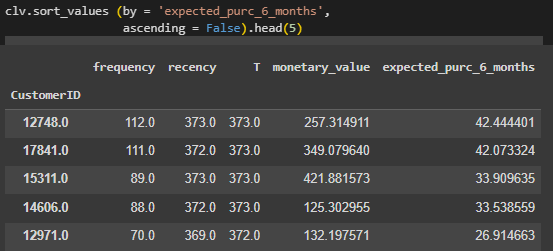

**Assumptions for Gamma-Gamma Model**

In order to use the Gamma-Gamma model, we need to make sure that there is no correlation between frequency and monetary value.

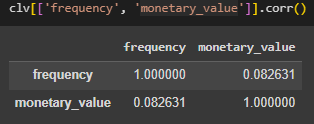

### **Gamma-Gamma Model**

After predicting the expected number of purchases of each customer. We need to use monetary value in order to predict CLV.

In [ ]:
ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(clv['frequency'],
        clv['monetary_value'])

clv['6_months_clv'] = ggf.customer_lifetime_value(bgf,
                                                    clv["frequency"],
                                                    clv["recency"],
                                                    clv["T"],
                                                    clv["monetary_value"],
                                                    time = 6,
                                                    freq = 'D',
                                                   discount_rate = 0.01)

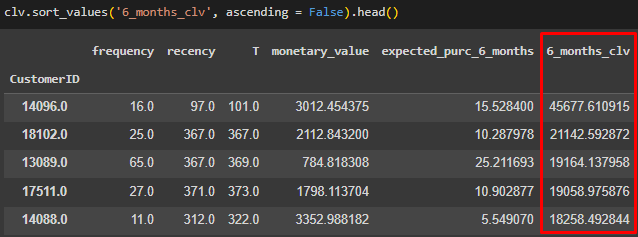

### **Segmentation CLV into Different Groups**

In [ ]:
clv['Segment'] = pd.qcut(clv['6_months_clv'], 4, labels = ['Hibernating',
                                                          'Need Attention',
                                                          'LoyalCustomers',
                                                          'Champions'])

# **Conclusion for CLV**

Method 2 and Method 3 are straightforward and can be easily computed using simple mathematical calculations. These methods provide a clear and understandable description to business users, making it easier for them to grasp the concepts.

On the other hand, Method 4 involves complex probabilistic models for calculations, making it more challenging to explain business users. The complexity may hinder their understanding and acceptance of the concept.

#WORKSHOP

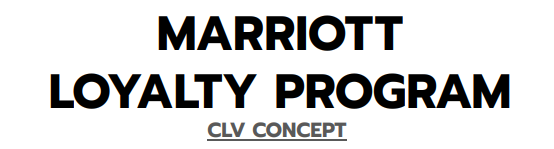

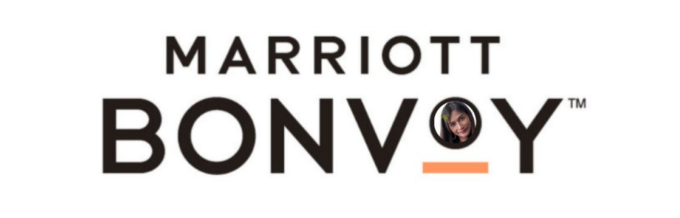

## **Problem statement:**

**Loss of opportunity to sell high segment hotel and Room type**

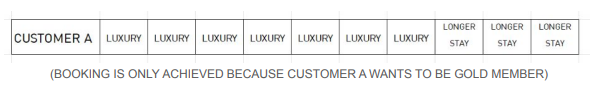

Customer A consistently stays at luxury accommodations but misses three nights, which prevents them from achieving Gold member status. As a result, they are required to buy a longer stay to attain the desired status.

This situation results in lowered revenue for the business, as the average spending of Customer A decreases due to the extra cost of extending their stay to meet the membership requirements.

**Can be improve**

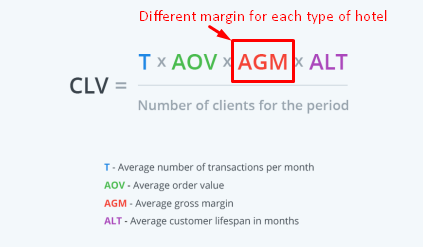

In this case, we use Method 2: CLV equation because each type of hotel have different margin

Use this method to re-calculate point for new loyalty tiers to treat them more excecutive.

**Existing loyalty program**

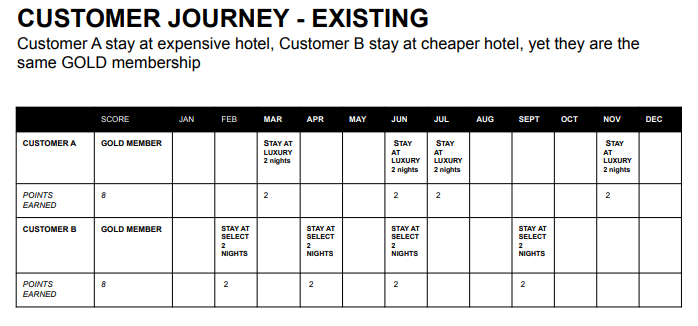

**Improved loyalty program by CLV**

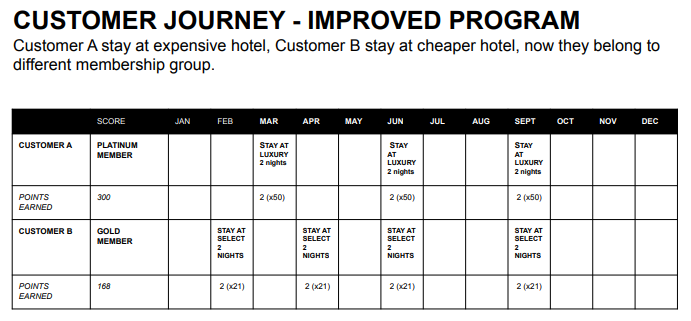

**To summarize**

1. New BONVOY loyalty program now uses new CLV equation to create
customer lifetime value
2. New BONVOY loyalty program now reflects true customer stay
3. New BONVOY loyalty program secures high spenders (where as
prior to this, high spenders may also have high churn rate)